In [1]:
import numpy as np
import cedalion
import cedalion.nirs
import cedalion.imagereco.forward_model as fw
import cedalion.datasets
import os
import cedalion.xrutils as xrutils
import cedalion.plots
import xarray as xr
import cedalion.geometry.landmarks as cd_landmarks
import matplotlib.pyplot as plt
import cedalion.sim.synthetic_hrf as synHRF_ced
from cedalion import units
import cedalion.dataclasses as cdc
import pyvista as pv
import cedalion.models.glm as glm
from cedalion.imagereco.solver import pseudo_inverse_stacked
#pv.set_jupyter_backend('server') # this enables interactive plots
import cedalion.sigproc.quality as quality

xr.set_options(display_expand_data=False);

## Loading and preprocessing the dataset

This notebook uses a HD whole head resting state dataset.

In [2]:
rec = cedalion.datasets.get_nn22_resting_state()

geo3d = rec.geo3d
meas_list = rec._measurement_lists["amp"]
amp = rec["amp"]

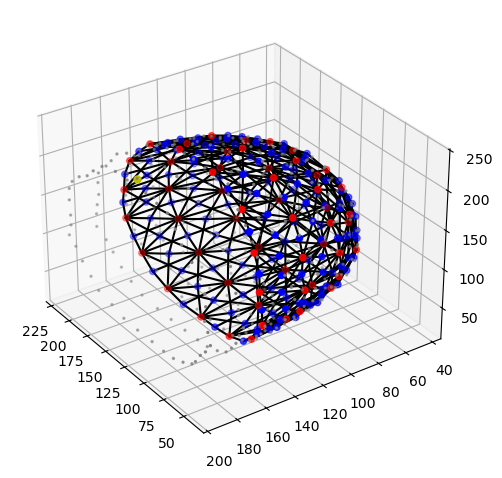

In [3]:
cedalion.plots.plot_montage3D(rec["amp"], geo3d)

In [4]:
amp = amp.pint.dequantify().pint.quantify("V")

In [5]:
snr_thresh = 10  # the SNR (std/mean) of a channel.
# SNR thresholding using the "snr" function of the quality subpackage
snr, snr_mask = quality.snr(rec["amp"], snr_thresh)
data_masked_snr_2, masked_elements_2 = xrutils.apply_mask(
    rec["amp"], snr_mask, "drop", "channel"
)

mask collapsed to channel dimension


In [6]:
od = cedalion.nirs.int2od(data_masked_snr_2)

## Construct headmodel

We load the the Colin27 headmodel, since we need the geometry for image reconstruction.

In [7]:
SEG_DATADIR, mask_files, landmarks_file = cedalion.datasets.get_colin27_segmentation()
SEG_DATADIR += '/colin27_segmentation'

In [8]:
head = fw.TwoSurfaceHeadModel.from_surfaces(
    segmentation_dir=SEG_DATADIR,
    mask_files = mask_files,
    brain_surface_file= os.path.join(SEG_DATADIR, "mask_brain.obj"),
    scalp_surface_file= os.path.join(SEG_DATADIR, "mask_scalp.obj"),
    landmarks_ras_file=landmarks_file,
    brain_face_count=None,
    scalp_face_count=None,
    fill_holes=True,        # needs to be true, otherwise landmark calculation fails
)

In [9]:
head.brain.units = cedalion.units.mm
head.scalp.units = cedalion.units.mm
head.landmarks = head.landmarks.pint.dequantify()
head.landmarks.pint.units = cedalion.units.mm

In [10]:
head.brain

TrimeshSurface(mesh=<trimesh.Trimesh(vertices.shape=(15002, 3), faces.shape=(29988, 3))>, crs='ijk', units=<Unit('millimeter')>)

In [11]:
head.landmarks

Magnitude,[[89.95007602497842 205.78946685790896 35.85887908935477] [91.75606727600317 25.05000305176084 17.14201354980642] [18.05000305175645 109.8805942535382 17.343021392821214] [165.94999694824514 112.9619064331096 17.922157287600022]]
Units,millimeter


head.landmarks contains the 4 landmarks ['Nz' 'Iz' 'LPA' 'RPA']. 
Since we want to create synthetic HRFs on the brain surface at landmark positions, we need to build the remaining 10-10 landmarks

In [12]:
lmbuilder = cd_landmarks.LandmarksBuilder1010(head.scalp, head.landmarks)
all_landmarks = lmbuilder.build()
head.landmarks = all_landmarks

/home/thomas/Dokumente/SHK/cedalion/src/cedalion/geometry/landmarks.py:233: UserWarning: WIP: distance calculation around ears
  warnings.warn("WIP: distance calculation around ears")


In [13]:
# geo3d_snapped = head.align_and_snap_to_scalp(geo3d)
center_brain = np.mean(head.brain.mesh.vertices, axis=0)

We want to build the synthetic HRFs at C3 and C4 (green dots in the image below)

In [14]:
plt_pv = pv.Plotter()
cedalion.plots.plot_surface(plt_pv, head.brain, color="#d3a6a1")
cedalion.plots.plot_surface(plt_pv, head.scalp, opacity=0.1)
cedalion.plots.plot_labeled_points(
    plt_pv, head.landmarks.sel(label=["C3", "C4"]), show_labels=True
)
#cedalion.plots.plot_labeled_points(
#    plt_pv,
#    geo3d_snapped[geo3d_snapped.type != cdc.PointType.LANDMARK],
#    show_labels=True,
#)
plt_pv.camera.position = (
    head.landmarks.sel(label="C3").values - center_brain
) * 7 + center_brain
plt_pv.show()

/home/thomas/anaconda3/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:338: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


Widget(value='<iframe src="http://localhost:36543/index.html?ui=P_0x79a40c0c8690_0&reconnect=auto" class="pyvi…

## Build spatial activation pattern on brain surface for landmarks C3 and C4

Using the the nearest brain vertex to a given landmark, we build a spatial activation pattern on the brain surface. The pattern is a Gaussian of the geodesic distance. The size is determined by the standard deviation of this Gaussian, given by the parameter 'spatial_scale'. The peak intensity is determined by the parameter 'intensity_scale'.

In [15]:
c3_seed = head.brain.mesh.kdtree.query(head.landmarks.sel(label='C3'))[1]
c4_seed = head.brain.mesh.kdtree.query(head.landmarks.sel(label='C4'))[1]

/home/thomas/anaconda3/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:338: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


In [16]:
spatial_img_c3 = synHRF_ced.build_spatial_activation(
    head,
    c3_seed,
    spatial_scale=2 * cedalion.units.cm,
    intensity_scale=1 * units.micromolar,
    hbr_scale=-0.4,
)
spatial_img_c4 = synHRF_ced.build_spatial_activation(
    head,
    c4_seed,
    spatial_scale=2 * cedalion.units.cm,
    intensity_scale=1 * units.micromolar,
    hbr_scale=-0.4,
)

/home/thomas/anaconda3/envs/cedalion/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/home/thomas/anaconda3/envs/cedalion/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve


The resulting xarray.DataArray contains an activation value for each vertex and chromophore on the brain surface. We will use this spatial information to create synthetic HRFs.

We concatenate the two patterns for C3 and C4 along dimension 'trial_type' to get a single xarray.DataArray with the spatial information for both landmarks.

In [17]:
# concatenate the two sptaial patterns on axis 2
spatial_imgs = xr.concat(
    [spatial_img_c3, spatial_img_c4], dim="trial_type"
).assign_coords(trial_type=["Stim C3", "Stim C4"])
spatial_imgs

Magnitude,[[[1.1680490708877154e-19 -4.672196283550862e-20] [1.6482267316649908e-20 -6.592906926659963e-21] [3.798147795868493e-21 -1.5192591183473973e-21] ... [0.0 -0.0] [0.0 -0.0] [0.0 -0.0]] [[0.0 -0.0] [0.0 -0.0] [0.0 -0.0] ... [1.067877266765594e-11 -4.271509067062377e-12] [2.336114086334534e-13 -9.344456345338137e-14] [1.043229461825297e-19 -4.172917847301188e-20]]]
Units,molar


## Plot spatial patterns @ C3 & C4

There exists a helper function to plot the patterns on the brain surface

In [18]:
plot = True

In [19]:
if plot:
    synHRF_ced.plot_spatial_activation(
        spatial_img_c3.sel(chromo="HbO"), head.brain, title="C3 Activation"
    )

Widget(value='<iframe src="http://localhost:36543/index.html?ui=P_0x79a40c0cb850_1&reconnect=auto" class="pyvi…

In [20]:
if plot:
    synHRF_ced.plot_spatial_activation(
        spatial_img_c4.sel(chromo="HbO"), head.brain, title="C4 Activation"
    )

Widget(value='<iframe src="http://localhost:36543/index.html?ui=P_0x79a414632c10_2&reconnect=auto" class="pyvi…

## Image Reconstruction

We run the cedalion image reconstruction functionality to be able to map from image to channel space. (See image_reconstruction example notebook).

In [21]:
#fwm = cedalion.imagereco.forward_model.ForwardModel(head, geo3d_snapped, meas_list)
#fluence_all, fluence_at_optodes = ...
# Adot = fwm.compute_sensitivity(fluence_all, fluence_at_optodes)

In [22]:
Adot = cedalion.io.load_Adot("/home/thomas/Dokumente/SHK/Data/Adot_ninja_colin.h5")

In [23]:
# we only map from brain vertices, not scalp
Adot_brain = Adot[:, (Adot.is_brain).values,:]
# we drop the pruned channels
Adot_brain = Adot_brain.sel(channel=od.channel)

In [24]:
Adot_stacked = (
    cedalion.imagereco.forward_model.ForwardModel.compute_stacked_sensitivity(
        Adot_brain
    )
)
nchans = Adot_stacked.shape[0] // 2
Adot_stacked = Adot_stacked.assign_coords(
    {"wavelength": ("flat_channel", [760.0] * nchans + [850.0] * nchans)}
)
Adot_stacked = Adot_stacked.set_xindex("wavelength")
Adot_stacked

/home/thomas/anaconda3/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:338: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


<xarray.DataArray (flat_channel: 1088, flat_vertex: 30004)> Size: 261MB
7.861e-17 8.798e-18 5.67e-18 2.755e-18 ... 3.957e-13 1.938e-11 4.76e-11
Coordinates:
  * wavelength  (flat_channel) float64 9kB 760.0 760.0 760.0 ... 850.0 850.0
Dimensions without coordinates: flat_channel, flat_vertex

In [25]:
B = pseudo_inverse_stacked(Adot_stacked)
nvertices = B.shape[0]//2
B = B.assign_coords({"chromo" : ("flat_vertex", ["HbO"]*nvertices  + ["HbR"]* nvertices)})
B = B.set_xindex("chromo")
B

<xarray.DataArray (flat_vertex: 30004, flat_channel: 1088)> Size: 261MB
-5.606e-15 3.317e-13 1.239e-15 -7.193e-14 ... -4.707e-14 1.761e-13 1.21e-11
Coordinates:
  * chromo   (flat_vertex) <U3 360kB 'HbO' 'HbO' 'HbO' ... 'HbR' 'HbR' 'HbR'
Dimensions without coordinates: flat_vertex, flat_channel

In [26]:
spatial_imgs_stacked = spatial_imgs.stack({"flat_vertex" : ["chromo", "vertex"]})
display(spatial_imgs_stacked)

Magnitude,[[1.1680490708877154e-19 1.6482267316649908e-20 3.798147795868493e-21 ... -0.0 -0.0 -0.0] [0.0 0.0 0.0 ... -4.271509067062377e-12 -9.344456345338137e-14 -4.172917847301188e-20]]
Units,molar


### We can now map our spatial patterns to channel space

In [27]:
spatial_chan_stacked = Adot_stacked @ spatial_imgs_stacked
spatial_chan_stacked

Magnitude,[[-7.690410076531467e-12 -1.8318963113226861e-06] [-9.570511252168453e-11 -1.1757971431160003e-06] [-1.68124169597383e-11 -4.923948947303622e-06] ... [7.194479308129718e-06 5.147909134962218e-07] [0.00020070429121187762 1.046134512827173e-05] [3.768653397260412e-08 2.0982297416559433e-07]]
Units,molar


In [28]:
# undo stacking of channels in flat_channel dimension
spatial_chan_wl1 = (
    spatial_chan_stacked[(spatial_chan_stacked.wavelength == 760.0).values, :]
    .rename({"flat_channel": "channel"})
    .drop_vars("wavelength")
)
spatial_chan_wl2 = (
    spatial_chan_stacked[(spatial_chan_stacked.wavelength == 850.0).values, :]
    .rename({"flat_channel": "channel"})
    .drop_vars("wavelength")
)
spatial_chan = xr.concat([spatial_chan_wl1, spatial_chan_wl2], dim="wavelength")
spatial_chan.coords["wavelength"] = [760.0, 850.0]
spatial_chan = spatial_chan.assign_coords(channel=od.channel)
spatial_chan = spatial_chan.pint.dequantify()

Show the spatial activation in channel space with a scalp plot.

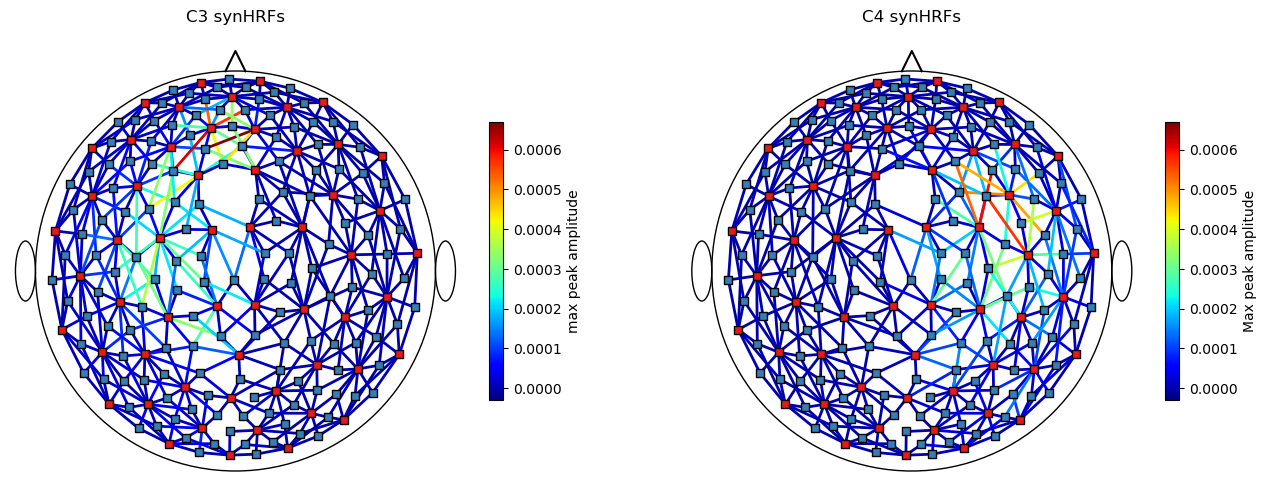

In [29]:
fig, ax = plt.subplots(1, 2)
# adjust plot size
fig.set_size_inches(16, 6)
cedalion.plots.scalp_plot(
    od,
    rec.geo3d,
    spatial_chan.sel(trial_type="Stim C3", wavelength=850).values,
    ax[0],
    cmap="jet",
    title="C3 synHRFs",
    vmin=spatial_chan.values.min(),
    vmax=spatial_chan.values.max(),
    cb_label="max peak amplitude",
)
cedalion.plots.scalp_plot(
    od,
    rec.geo3d,
    spatial_chan.sel(trial_type="Stim C4", wavelength=850).values,
    ax[1],
    cmap="jet",
    title="C4 synHRFs",
    vmin=spatial_chan.values.min(),
    vmax=spatial_chan.values.max(),
    cb_label="Max peak amplitude",
)
plt.show()

In [30]:
# Get top 5 channels for each trial type where synthetic activation is highest
top5_chans_idx_c3 = np.argpartition(
    spatial_chan.sel(trial_type="Stim C3").values.max(axis=0), -5
)[-5:]
top5_chans_idx_c4 = np.argpartition(
    spatial_chan.sel(trial_type="Stim C4").values.max(axis=0), -5
)[-5:]
roi_chans_c3 = od.channel[top5_chans_idx_c3]
roi_chans_c4 = od.channel[top5_chans_idx_c4]

In [31]:
# FIXME: Our spatial_chan is in od. We need to map it to channel space again so we can
# rescale the amplitude.
# We want a max amplitude of 1 micromolar in our synthetic activation, but it got
# scaled by the forward model.

In [32]:
dpf = xr.DataArray(
    [6, 6],
    dims="wavelength",
    coords={"wavelength": rec["amp"].wavelength},
)

In [33]:
# add time axis with one time point so we can convert to conc
spatial_chan_w_time = spatial_chan.expand_dims("time")
spatial_chan_w_time = spatial_chan_w_time.assign_coords(time=[0])
spatial_chan_w_time.time.attrs["units"] = "second"
spatial_chan_conc = cedalion.nirs.od2conc(
    spatial_chan_w_time, geo3d, dpf, spectrum="prahl"
)

In [34]:
# rescale so that synthetic hrfs add 1 micromolar at peak.
rescale_factor = (1* units.micromolar / spatial_chan_conc.max())
spatial_chan *= rescale_factor

## HRFs in channel Space

We build our temporal HRF model with the same functionality that generates hrf regressors for the GLM.

First we select a basis function, which defines the temporal shape of the HRF.

In [35]:
basis_fct = glm.Gamma(tau=0 * units.s, sigma=3 * units.s, T=3 * units.s)

In [36]:
od.time

<xarray.DataArray 'time' (time: 3310)> Size: 26kB
0.0 0.1112 0.2225 0.3337 0.445 0.5562 ... 367.6 367.7 367.8 367.9 368.0 368.1
Coordinates:
  * time     (time) float64 26kB 0.0 0.1112 0.2225 0.3337 ... 367.9 368.0 368.1
    samples  (time) int64 26kB 0 1 2 3 4 5 6 ... 3304 3305 3306 3307 3308 3309
Attributes:
    units:    second

### A Stim DataFrame, which contains the onset, duration and amplitude of the synthetic HRFs, is created.

In [37]:
stim_df = synHRF_ced.build_stim_df(
    max_time=od.time.values[-1] * units.seconds,
    trial_types=["Stim C3", "Stim C4"],
    min_interval=10 * units.seconds,
    max_interval=20 * units.seconds,
    min_stim_dur = 10 * units.seconds,
    max_stim_dur = 10 * units.seconds,
    min_stim_value = 1.0,
    max_stim_value = 1.0,
    order="random",
)

In [38]:
stim_df.head()

,onset,duration,value,trial_type
0,17.09,10.0,1.0,Stim C3
1,44.44,10.0,1.0,Stim C4
2,65.08,10.0,1.0,Stim C3
3,91.84,10.0,1.0,Stim C3
4,116.25,10.0,1.0,Stim C3
5,141.87,10.0,1.0,Stim C4
6,171.85,10.0,1.0,Stim C4
7,196.82,10.0,1.0,Stim C3
8,224.63,10.0,1.0,Stim C3
9,247.61,10.0,1.0,Stim C4


### We can now use our stim dataframe, basis function, and spatial information to create the synthetic HRF timeseries

In [ ]:
syn_ts = synHRF_ced.build_synthetic_hrf_timeseries(od, stim_df, basis_fct, spatial_chan)

### We get a synthetic HRF timeseries for each channel, trial_type and chromo / wavelength

In [ ]:
syn_ts

Magnitude,[[[[-0.0 -0.0 -0.0 ... -0.0 -0.0 -0.0] [-0.0 -0.0 -0.0 ... -0.0 -0.0 -0.0]] [[-0.0 -0.0 -0.0 ... -0.0 -0.0 -0.0] [-0.0 -0.0 -0.0 ... -0.0 -0.0 -0.0]] [[-0.0 -0.0 -0.0 ... -0.0 -0.0 -0.0] [-0.0 -0.0 -0.0 ... -0.0 -0.0 -0.0]] ... [[-0.0 -0.0 -0.0 ... -0.0 -0.0 -0.0] [-0.0 -0.0 -0.0 ... -0.0 -0.0 -0.0]] [[-0.0 -0.0 -0.0 ... -0.0 -0.0 -0.0] [-0.0 -0.0 -0.0 ... -0.0 -0.0 -0.0]] [[-0.0 -0.0 -0.0 ... -0.0 -0.0 -0.0] [-0.0 -0.0 -0.0 ... -0.0 -0.0 -0.0]]] [[[0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0]] [[0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0]] [[0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0]] ... [[0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0]] [[0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0]] [[0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0]]]]
Units,dimensionless


### Sum the synthetic timeseries over trial_type dimension, so it has the same shape as the resting state data

In [ ]:
syn_ts_sum = syn_ts.sum(dim='trial_type')
syn_ts_sum

Magnitude,[[[0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0] ... [0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0]] [[0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0] ... [0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0]]]
Units,dimensionless


## Add HRFs to the Data

In [ ]:
od_w_hrf = od + syn_ts_sum

## Recover the HRFs from (Resting Data + syn HRFs)

We filter the data and calculate block averages over epochs to recover the HRFs

In [ ]:
od_w_hrf_filtered = od_w_hrf.cd.freq_filter(fmin=0.02, fmax=0.5, butter_order=4)

In [ ]:
epochs = od_w_hrf_filtered.cd.to_epochs(
    stim_df,  # stimulus dataframe
    ["Stim C3", "Stim C4"],  # select events
    before=5,  # seconds before stimulus
    after=20,  # seconds after stimulus
)

# calculate baseline
baseline = epochs.sel(reltime=(epochs.reltime < 0)).mean("reltime")
# subtract baseline
epochs_blcorrected = epochs - baseline

# group trials by trial_type. For each group individually average the epoch dimension
blockaverage = epochs_blcorrected.groupby("trial_type").mean("epoch")

n_roi = roi_chans_c3.size
# show results
f, ax = plt.subplots(2, n_roi, figsize=(16, 8))
ax = ax.flatten()
for i_ch, ch in enumerate(roi_chans_c3):
    for ls, trial_type in zip(["-", "--"], blockaverage.trial_type):
        ax[i_ch].plot(
            blockaverage.reltime,
            blockaverage.sel(wavelength=760, trial_type=trial_type, channel=ch),
            "r",
            lw=2,
            ls=ls,
        )
        ax[i_ch].plot(
            blockaverage.reltime,
            blockaverage.sel(wavelength=850, trial_type=trial_type, channel=ch),
            "b",
            lw=2,
            ls=ls,
        )
    ax[i_ch].grid(1)
    ax[i_ch].set_title(ch.values)
    ax[i_ch].set_ylim(-0.05, 0.05)

for i_ch, ch in enumerate(roi_chans_c4):
    for ls, trial_type in zip(["-", "--"], blockaverage.trial_type):
        ax[i_ch + n_roi].plot(
            blockaverage.reltime,
            blockaverage.sel(wavelength=760, trial_type=trial_type, channel=ch),
            "r",
            lw=2,
            ls=ls,
        )
        ax[i_ch + n_roi].plot(
            blockaverage.reltime,
            blockaverage.sel(wavelength=850, trial_type=trial_type, channel=ch),
            "b",
            lw=2,
            ls=ls,
        )
    ax[i_ch + n_roi].grid(1)
    ax[i_ch + n_roi].set_title(ch.values)
    ax[i_ch + n_roi].set_ylim(-0.05, 0.05)

plt.suptitle(
    "Blockaverage for channels most sensitive to C3 (top) and C4 (bottom): 760nm: r | 850nm: b | C3: - | C4: --"
)
plt.tight_layout()
plt.show()

## Map block average back to brain surface

We map our extracted block averages back to the brain surface to visualize the recovered HRFs activation for Stim C3.
We can compare it to the synthetic HRF images we created earlier.

In [ ]:
blockaverage_img = B @ blockaverage.stack({"flat_channel" : ["wavelength", "channel"]})

In [ ]:
# plot HbO time trace of left and right brain hemisphere during FTapping/Right

for view in ["left_hemi", "right_hemi"]:
    trial_type = "Stim C3"
    gif_fname = "Ftapping-right" + "_HbO_" + view + ".gif"

    hbo = (
        blockaverage_img.sel(chromo="HbO", trial_type=trial_type).pint.dequantify()
        / 1e-5
    )  # FIXME unit handling
    hbo_brain = hbo

    ntimes = hbo.sizes["reltime"]

    b = cdc.VTKSurface.from_trimeshsurface(head.brain)
    b = pv.wrap(b.mesh)
    b["reco_hbo"] = hbo_brain[:, 0] - hbo_brain[:, 0]

    p = pv.Plotter()

    p.add_mesh(
        b,
        scalars="reco_hbo",
        cmap="seismic",  # 'gist_earth_r',
        clim=(-2.5, 2.5),
        scalar_bar_args={"title": "HbO / µM"},
        smooth_shading=True,
    )

    tl = lambda tt: f"{trial_type} HbO rel. time: {tt:.3f} s"
    time_label = p.add_text(tl(0))

    cog = head.brain.vertices.mean("label").values
    if view == "left_hemi":
        p.camera.position = cog + [-400, 0, 0]
    else:
        p.camera.position = cog + [400, 0, 0]
    p.camera.focal_point = cog
    p.camera.up = [0, 0, 1]
    p.reset_camera()

    p.open_gif(gif_fname)

    for i in range(0, ntimes, 3):
        b["reco_hbo"] = hbo_brain[:, i] - hbo_brain[:, 0]
        time_label.set_text("upper_left", tl(hbo_brain.reltime[i]))

        p.write_frame()

    p.close()

/home/thomas/anaconda3/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:338: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/home/thomas/anaconda3/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:338: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


In [ ]:
from IPython.display import Image
display(Image(data=open("Ftapping-right_HbO_left_hemi.gif",'rb').read(), format='png'))
display(Image(data=open("Ftapping-right_HbO_right_hemi.gif",'rb').read(), format='png'))